In [1]:
import xarray as xr 
import numpy as np
import math 
import glob
import s3fs 
import warnings 
import matplotlib.pyplot as plt
import xgcm

In [2]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [3]:
ds = open_s3fs('PC-data')
ds

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [4]:
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })

fsg.ls('s3://data')
data_path = f's3://data/CREG12.L75-REF08_mesh_hgr.nc'
remote_files = fsg.glob(data_path)
fileset = [fsg.open(file) for file in remote_files]
dm = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
dm

<xarray.Dataset>
Dimensions:       (t: 1, x: 1580, y: 1801, z: 75)
Dimensions without coordinates: t, x, y, z
Data variables: (12/21)
    nav_lon       (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lev       (z) float32 dask.array<chunksize=(75,), meta=np.ndarray>
    time_counter  (t) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    glamt         (t, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    glamu         (t, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    ...            ...
    e1f           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2t           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2u           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2v           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2f           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    ff            (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
Attributes:
    file_name:  mesh_hgr.nc
    TimeStamp:  06/06/2019 11:25:45 +0200

In [5]:
zonal = dm.e1u.isel(y=slice(900,1800), x=slice(200,1400)).squeeze(axis=0)
merd = dm.e2u.isel(y=slice(900,1800), x=slice(200,1400)).squeeze(axis=0)

In [6]:
d = ds.mbathy.isel(y=slice(900,1800), x=slice(200,1400))

In [18]:
delta_zonal = zonal.isel(x=slice(0,1199))
delta_dx = d.diff(dim='x')

delta_merd = merd.isel(y=slice(0,899))
delta_dy = d.diff(dim='y')

In [23]:
print(delta_dy)
delta_merd

<xarray.DataArray 'mbathy' (y: 899, x: 1200)>
dask.array<sub, shape=(899, 1200), dtype=int16, chunksize=(899, 1200), chunktype=numpy.ndarray>
Coordinates:
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(899, 1200), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(899, 1200), meta=np.ndarray>
Dimensions without coordinates: y, x


<xarray.DataArray 'e2u' (y: 899, x: 1200)>
dask.array<getitem, shape=(899, 1200), dtype=float64, chunksize=(899, 1200), chunktype=numpy.ndarray>
Dimensions without coordinates: y, x

In [21]:
grad_d = (delta_dx/delta_zonal) + (delta_dy/delta_merd)

ValueError: arguments without labels along dimension 'y' cannot be aligned because they have different dimension sizes: {899, 900}

In [8]:
d = ds.mbathy.isel(y=slice(900,1800), x=slice(200,1400))

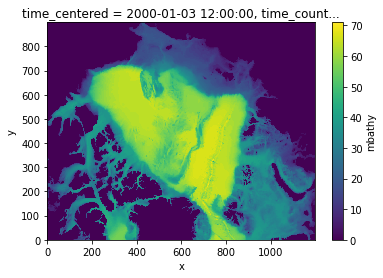

In [10]:
d.plot()

In [35]:
d[:,0].shape

(900,)

In [11]:
lat = ds.nav_lat.isel(y=slice(900,1800), x=slice(200,1400))
lon = ds.nav_lon.isel(y=slice(900,1800), x=slice(200,1400))

Length in meters of 1° of latitude = always 111.32 km

Length in meters of 1° of longitude = 40075 km * cos( latitude ) / 360

In [12]:
lat_m = lat*111.32*10**3
lon_m = (40075*10**3*np.cos(np.deg2rad(lat)))/360

In [33]:
lon_m.values

array([[45882.39860824, 45847.69674266, 45812.93847826, ...,
        46161.22776642, 46214.73034637, 46268.22960873],
       [45844.93651779, 45810.1915237 , 45775.37022531, ...,
        46116.91819504, 46170.50371443, 46224.08591625],
       [45807.56731952, 45772.76924418, 45737.91808759, ...,
        46072.7214213 , 46126.36333952, 46180.01852805],
       ...,
       [55257.67821819, 55234.07365092, 55210.44254303, ...,
        56738.15402306, 56775.64265413, 56813.15782583],
       [55309.20020408, 55285.63544775, 55262.05742111, ...,
        56793.49785878, 56830.90686798, 56868.34241781],
       [55360.76200091, 55337.26359614, 55313.74860348, ...,
        56848.86823512, 56886.1909873 , 56923.54691525]])

In [41]:
lon_m

<xarray.DataArray 'nav_lat' (y: 900, x: 1200)>
dask.array<truediv, shape=(900, 1200), dtype=float64, chunksize=(900, 1200), chunktype=numpy.ndarray>
Coordinates:
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
Dimensions without coordinates: y, x

In [42]:
hb_lon = np.full((900,1200),np.zeros)
hb_lat = np.full((900,1200),np.zeros)

In [ ]:
warnings.simplefilter("ignore")

for i, val in enumerate(lon_m[:,0]):    
    hb_lon[i,:] = np.gradient(d[i,:],lon_m[i,:],axis=0)

In [40]:
warnings.simplefilter("ignore")

for i, val in enumerate(lat_m[:,0]):    
    hb_lon[i,:] = np.gradient(d[i,:],lon_m[i,:],axis=0)

(900,)

## CREG12.L75-REF08_mesh_hgr.nc

includes all horizontal metrics for each grid points as well. 
for instance  for the scalars such as temperature and salinity, T-point, the scale factors to use are e1t (zonal) e2t (meridional).
They are invariant over the depth


In [11]:
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })

fsg.ls('s3://data')
data_path = f's3://data/CREG12.L75-REF08_mesh_hgr.nc'
remote_files = fsg.glob(data_path)
fileset = [fsg.open(file) for file in remote_files]
dm = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
dm

<xarray.Dataset>
Dimensions:       (t: 1, x: 1580, y: 1801, z: 75)
Dimensions without coordinates: t, x, y, z
Data variables: (12/21)
    nav_lon       (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lev       (z) float32 dask.array<chunksize=(75,), meta=np.ndarray>
    time_counter  (t) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    glamt         (t, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    glamu         (t, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    ...            ...
    e1f           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2t           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2u           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2v           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2f           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    ff            (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
Attributes:
    file_name:  mesh_hgr.nc
    TimeStamp:  06/06/2019 11:25:45 +0200

In [9]:
zonal = dm.e1u.isel(y=slice(900,1800), x=slice(200,1400)).squeeze(axis=0)
merd = dm.e2u.isel(y=slice(900,1800), x=slice(200,1400)).squeeze(axis=0)


"zonal_v = dm.e1v.isel(y=slice(900,1800), x=slice(200,1400)).squeeze(axis=0)\nmerd_v = dm.e2v.isel(y=slice(900,1800), x=slice(200,1400)).squeeze(axis=0)\n\n# merging u and v \nmerd = xr.merge([merd_u,merd_v],combine_attrs = 'override')\nzonal = xr.merge([zonal_u,zonal_v],combine_attrs = 'override')\n\nzonal"

In [10]:
metrics = {
    ('X',): ['dxF', 'dxC', 'dxG'],    # X distances
    ('Y',): ['dyF', 'dyC', 'dyG'],    # Y distances
}
grid = xgcm.Grid(d
                 , metrics=zonal
                 , periodic=False
                 )

AttributeError: 'DataArray' object has no attribute 'items'

In [88]:
d_zon_hb = xgcm.Grid.derivative(hb_d,zonal_u,axis=[0,1])

AttributeError: 'DataArray' object has no attribute 'axes'